# This notebook contains the functions used to disaggregate the price data received from the ETM model for use in the EVM model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
import statistics
import time

In [2]:
#input original price data

df = pd.read_csv('electricity_price.csv', usecols = ['Price (Euros)'])
df2 = pd.DataFrame()
df2['electricity price 15min'] = np.repeat(df['Price (Euros)'],4)
df2 = df2.reset_index(drop=True)

In [3]:
def check_pos_neg_zero(data):
    '''
    converts elements in a list of data to 1, 0, -1 based on if the values in the data
    are respectively positive, zero or negative
    
    Input:
    data: list of floats
    
    Output:
    list of 1, 0, -1 values of length len(data)
    
    '''
    check_list = [0] * len(data)
    for i in range(len(data)):
    
        if data[i] > 0:
            #print(i, ' is larger than zero')
            check_list[i] = 1
    
        elif data[i] < 0:
            check_list[i] = -1
            #print(i, ' is smaller than zero')
    
    return check_list

def test_relative_price_change(df_agg,df_disagg,print_result=False):
    '''
    compares the similarity of the general direction of change (up, flat, down) 
    of two datasets
    
    Input:
    df_agg: dataframe column, float numbers
    df_disagg: dataframe column, float numbers
    print_results: boolean (True/False), generate ouput statistics
    
    Output:
    float number, similarity percentage
    
    '''
    similarity_count = 0
    
    agg_hour_diff = df_agg.diff().fillna(0)
    disagg_hour_diff = df_disagg.groupby(np.arange(len(df_disagg))//4).mean().diff().fillna(0)
    
    relative_change_agg = check_pos_neg_zero(agg_hour_diff)
    relative_change_disagg = check_pos_neg_zero(disagg_hour_diff)
    
    if len(relative_change_agg) != len(relative_change_disagg):
        print('TROUBLE: lenghts do not align: {} df_agg, {} df_disagg'.format(len(relative_change_agg), len(relative_change_disagg)))
        return 0
    
    for i in range(len(relative_change_agg)):
        
        if relative_change_agg[i] == relative_change_disagg[i]:
            similarity_count += 1
    
    similarity_percentage = similarity_count/len(relative_change_agg)*100
    
    if print_result:
        print('The data changes similarly for {} out of {} hours ({}%)'.format(similarity_count,\
                len(relative_change_agg),round(similarity_percentage,1)))
    
    return similarity_percentage
    
def create_rolling_average(df,rolling_window):
    '''
    Disaggregated price data based on (centered) rolling average technique
    
    Input:
    df: dataframe column, 35040 float numbers (aggregate data repeated *4)
    rolling_window: window size of rolling average technique
    
    Ouput:
    dataframe column, 8760 float numbers (disaggregated data)
    '''
    return df.rolling(window = rolling_window, center= True, min_periods = 1).mean()


In [2]:
def reverse_rolling_average(rolled_list,first_nrs,window): 
    '''
    Mathematically reverses datasets produced by create_rolling_average function.
    N.B. this function is specificly designed to reverse Centered rolling average disaggregates
    
    Input:
    rolled_list: data disaggregated by the create_rolling_average function
    first_nrs: reversion requires the storage of the first int(window/2) numbers
    window: window size of rolling average technique
    
    Ouput:
    list of 35040 values, representing the aggregated data (repeated *4) used in the disaggregation
    of rolled_list
    '''
    
    original_values = first_nrs
    for i in range(len(rolled_list)):
        
        if window % 2 == 0:
            begin = int(max(0,i-round(window/2,0)))
            end = int(min(len(rolled_list),i+round(window/2,0)))
            length_needed = end-begin
            #print(begin,end,length_needed)
        else:
            #print('uneven window')
            begin = int(max(0,i-round((window-1)/2,0)))
            end = int(min(len(rolled_list),i+1+round((window-1)/2,0)))
            length_needed = end-begin
            #print(begin,end,length_needed)
        
        #print('original values selected {} to {}. data present: {}'.format(begin ,end, original_values[begin:end]))
        #print('values {} plus x must average {}'.format(original_values[begin:end],rolled_list[i]))
        
        if i == 0 and (len(original_values[begin:end]) != length_needed or round(statistics.mean(original_values[begin:end]),3) != round(rolled_list[i],3)):
            print('invalid first values. Provide appropriate data')
            return 0
        
        #print('values {} are size {} and average {} (should be {})\n'.format(original_values[begin:end],length_needed,statistics.mean(original_values[begin:end]),rolled_list[i]))
        if len(original_values[begin:end]) == length_needed and round(statistics.mean(original_values[begin:end]),3) == round(rolled_list[i],3):
            #print('values {} already are size {} and average {}\n'.format(original_values[begin:end],length_needed,rolled_list[i]))
            continue
        
        value = length_needed * rolled_list[i] - sum(original_values[begin:end])
        #print('value {} completes average '.format(round(value,3)))
        
        original_values.append(round(value,5))
        #print('')
        
    return original_values

In [5]:
def thrashing_test(df,thrash_iterations,rolling_window,plot=False):
    '''
    Thrashing test for rolling average technique. Repeatedly disaggregates and 
    aggregates a dataset and displays the resulting effects
    
    Input:
    df: original (aggregate) data, length must equate to 35040
    thrash_iterations: integer, specifies the amount of subsequent disaggregations and aggregations
    rolling_window: window size of rolling average technique
    Plot: Boolean (True/False), choice to display graphs from results
    
    Output: 
    list of float values of the change in the mean and standard deviation of the data throughout thrashing
    
    '''
    
    start = time.time()
    df_iteration = pd.DataFrame()
    df_iteration = df.copy()
    mean_progression = []
    std_progression = []
    mean_progression.append(df['electricity price 15min'].mean())
    std_progression.append(df['electricity price 15min'].std())
    
    
    for i in range(thrash_iterations):
        first_values = [df_iteration['electricity price 15min'][i] for i in range(int(math.ceil(rolling_window/2)))]
        #first_values = df_iteration[:int(math.ceil(rolling_window/2))].to_list()
    
        disagg = create_rolling_average(df_iteration,rolling_window)
        agg = reverse_rolling_average(disagg['electricity price 15min'].to_list(),first_values,rolling_window)
        
        df_iteration['electricity price 15min'] = agg 
        
        mean_progression.append(statistics.mean(agg))
        std_progression.append(statistics.stdev(agg))
        if i%100 == 0 and i != 0:
            print('iteration {} complete'.format(i))
    
    end = time.time()
    
    
    if plot == True:
        mean_progression_mean = statistics.mean(mean_progression)
        std_progression_mean = statistics.mean(std_progression)
        #print(mean_progression_mean,std_progression_mean)
        
        #print(mean_progression,std_progression)
        
        fig, (ax1,ax2) = plt.subplots(2,1,figsize=(15, 10))
        ax1.plot(mean_progression,label = 'mean per thrashing iteration',alpha=0.9)
        ax1.hlines(y = mean_progression[0], xmin = 0, xmax = len(mean_progression)-1,color = 'red',label='original mean value',alpha=0.9)
        ax1.hlines(y = mean_progression_mean, xmin = 0, xmax = len(mean_progression)-1,\
                   color = 'green',label='thrashed values mean',alpha = 0.8,linestyle=':')
        
        ax1.set_title('Change in mean of price data during thrashing (window = {}, thrashing error = {})'.format(\
                      rolling_window,round(abs(mean_progression[0]-mean_progression_mean),8)))
        ax1.set_ylabel('Price (€/MWh)')
        ax1.set_xlabel('Performed A/D iterations')
        ax1.set_ylim([mean_progression[0] - 10, mean_progression[0] + 10])
        ax1.legend(loc = 'upper right')
        
        
        ax2.plot(std_progression,label = 'std per thrashing iteration',alpha=0.9)
        ax2.hlines(y = std_progression[0], xmin = 0, xmax = len(std_progression)-1,color = 'red',label='original std value',alpha=0.9)
        ax2.hlines(y = std_progression_mean, xmin = 0, xmax = len(std_progression)-1,\
                   color = 'green',label='thrashed values mean',alpha = 0.8,linestyle=':')
        
        ax2.set_title('Change in standard deviation of price data during thrashing (window = {}, thrashing error = {})'.format(\
                        rolling_window,round(abs(std_progression[0]-std_progression_mean),8)))
        ax2.set_ylabel('Price (€/MWh)')
        ax2.set_xlabel('Performed A/D iterations')
        ax2.set_ylim([std_progression[0] - 10, std_progression[0] + 10])
        ax2.legend(loc = 'upper right')
        
        plt.show()
    
    print('Thrashing test took {} seconds, {} seconds per A/D round'.format(round(end - start,3),round((end-start)/thrash_iterations,3)))
    print('\n\n')
    
    return(mean_progression, std_progression,agg)  

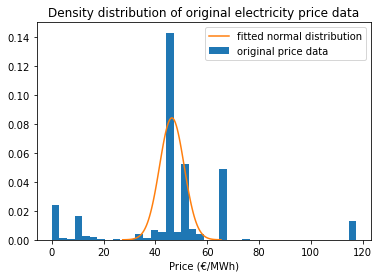

Chance of drawing: min 1.5344757198106517e-22, max 0.06271426442991905


In [6]:
# fit normal distribution to dataset for further reference
# normal distribution fits too poorly to be used for disaggregation

plt.hist(df['Price (Euros)'], density=True,bins = 40, label='original price data')

mean = df['Price (Euros)'].mean()
sigma = math.sqrt(df['Price (Euros)'].std()) #sigma is the square root of a standard deviation
x = np.linspace(mean - 4*sigma, mean + 4*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mean, sigma), label= 'fitted normal distribution')

plt.title('Density distribution of original electricity price data')
plt.xlabel('Price (€/MWh)')
plt.legend()
plt.show()

print('Chance of drawing: min value in orignal data {}, idem max value {}'.format(stats.norm(mean,sigma).pdf(0),stats.norm(mean,sigma).pdf(117.48-(45*1.5))))

Text(0.5, 0, 'time (15 minutes)')

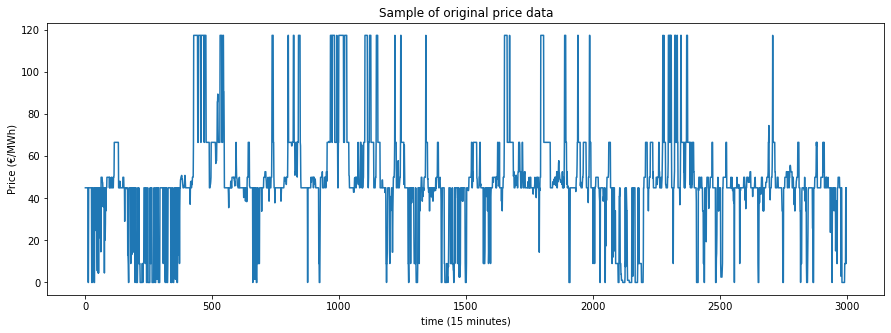

In [7]:
# plot a sample of the original price data of the ETM.
# bad fit of normal distribution explained by clear 
# discrete steps in price instead of continuous prices

plt.figure(figsize=(15, 5))
plt.plot(df['Price (Euros)'][:3000])

plt.title('Sample of original price data')
plt.ylabel('Price (€/MWh)')
plt.xlabel('time (15 minutes)')

In [8]:
#generate rolling averages for various windows

original_data = df2['electricity price 15min'].to_list()

rolling_4 = df2['electricity price 15min'].rolling(window = 4, center= True, min_periods = 1).mean().to_list()
rolling_8 = df2['electricity price 15min'].rolling(window = 8, center= True, min_periods = 1).mean().to_list()
rolling_12 = df2['electricity price 15min'].rolling(window = 12, center= True, min_periods = 1).mean().to_list()
rolling_16 = df2['electricity price 15min'].rolling(window = 16, center= True, min_periods = 1).mean().to_list()

#invere rolling averages to regain original data
reversed_4 = reverse_rolling_average(rolling_4,[45,45],4)
reversed_8 = reverse_rolling_average(rolling_8,[45,45,45,45],8)
reversed_12 = reverse_rolling_average(rolling_12,[45,45,45,45,45,45],12)
reversed_16 = reverse_rolling_average(rolling_16,[45,45,45,45,45,45,45,45],16)

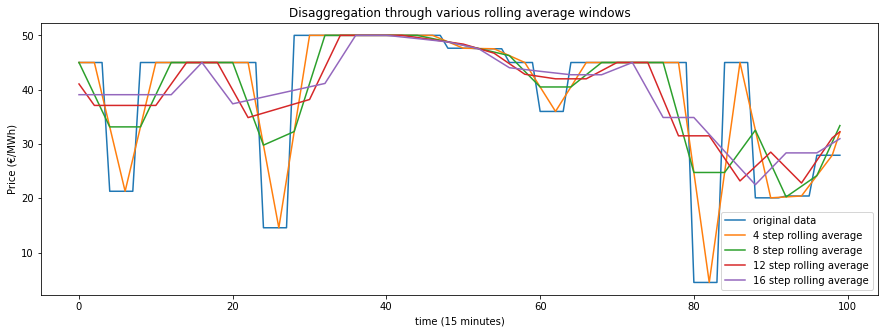

In [9]:
# plot samples of disaggregate price data for verification

plt.figure(figsize=(15, 5))
plt.plot(original_data[220:320],label='original data')
plt.plot(rolling_4[220:320],label = '4 step rolling average')
plt.plot(rolling_8[220:320],label = '8 step rolling average')
plt.plot(rolling_12[220:320],label = '12 step rolling average')
plt.plot(rolling_16[220:320],label = '16 step rolling average')

plt.title('Disaggregation through various rolling average windows')
plt.ylabel('Price (€/MWh)')
plt.xlabel('time (15 minutes)')
plt.legend(loc='lower right')

In [1]:
#calculate the similarity of rolling averages when varying the window from 1 to 25
x = []
y = []
df3 = pd.DataFrame()

for i in range(1,25):
    df3['rolling {} hours'.format(i)] = create_rolling_average(df2['electricity price 15min'],i)
    percentage = test_relative_price_change(df['Price (Euros)'],df3['rolling {} hours'.format(i)])
    #print(i,100-percentage)
    
    x.append(i)
    y.append(percentage)

NameError: name 'pd' is not defined

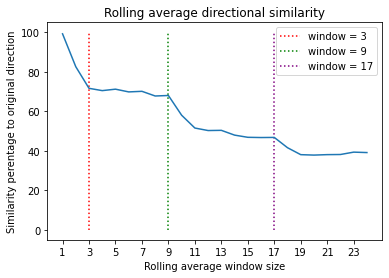

In [11]:
#plot the similarities

plt.plot(x,y)
plt.vlines(3, 0, 100, colors='red', linestyles=':',label= 'window = 3')
plt.vlines(9, 0, 100, colors='green', linestyles=':',label= 'window = 9')
plt.vlines(17, 0, 100, colors='purple', linestyles=':',label= 'window = 17')
plt.title('Rolling average directional similarity')
plt.ylabel('Similarity perentage to original direction')
plt.xlabel('Rolling average window size')
xticks = np.arange(min(x), max(x)+1,2)
plt.xticks(xticks)
plt.legend()
plt.show()

#percent of the time that the derivative of the rolled average is the same as the original

lower error due to error being spread over a larger subsection of values


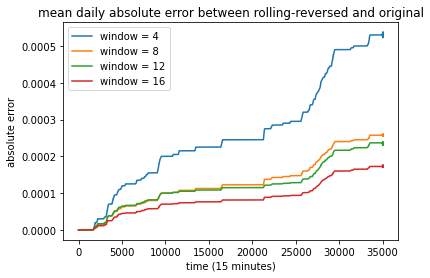

In [12]:
# plot whether the mean error of the reverse roling average method increases as it 
# goes further through the dataset. This could indicate a weakness of the rolling
# average method for use on larger datasets

difference_4 = pd.DataFrame([abs(reversed_4[i]-original_data[i]) for i in range(len(reversed_4))])
difference_8 = pd.DataFrame([abs(reversed_8[i]-original_data[i]) for i in range(len(reversed_8))])
difference_12 = pd.DataFrame([abs(reversed_12[i]-original_data[i]) for i in range(len(reversed_12))])
difference_16 = pd.DataFrame([abs(reversed_16[i]-original_data[i]) for i in range(len(reversed_16))])


plt.plot(create_rolling_average(difference_4,24*4),label = 'window = 4')
plt.plot(create_rolling_average(difference_8,24*4),label = 'window = 8')
plt.plot(create_rolling_average(difference_12,24*4),label = 'window = 12')
plt.plot(create_rolling_average(difference_16,24*4),label = 'window = 16')

plt.title('mean daily absolute error between rolling-reversed and original')
plt.ylabel('absolute error')
plt.xlabel('time (15 minutes)')
plt.legend()

print('lower error due to error being spread over a larger subsection of values')

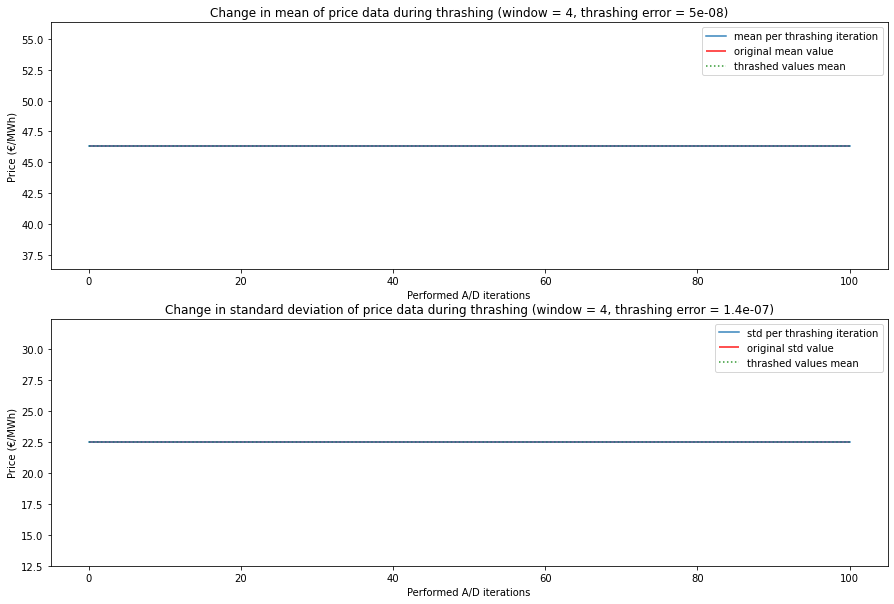

Thrashing test took 58.52 seconds, 0.585 seconds per A/D round





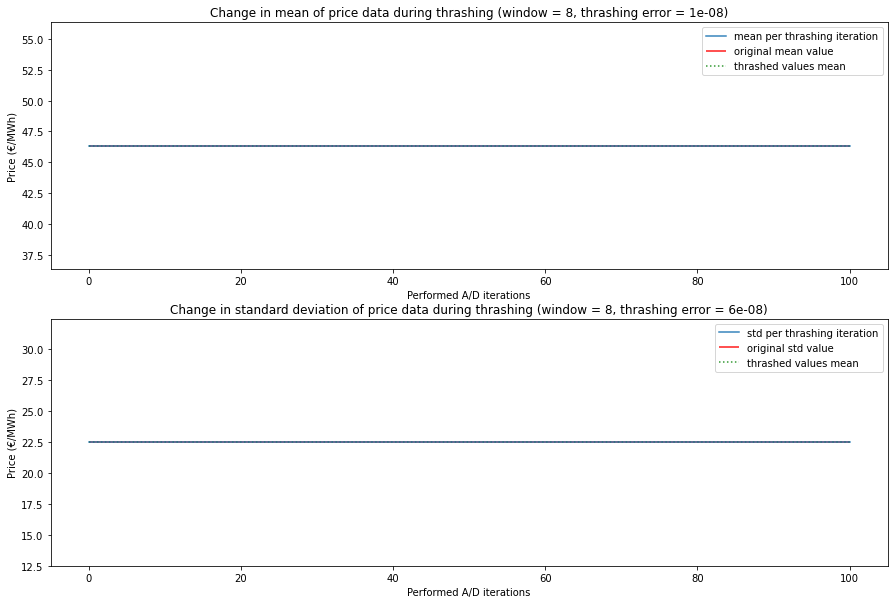

Thrashing test took 64.388 seconds, 0.644 seconds per A/D round





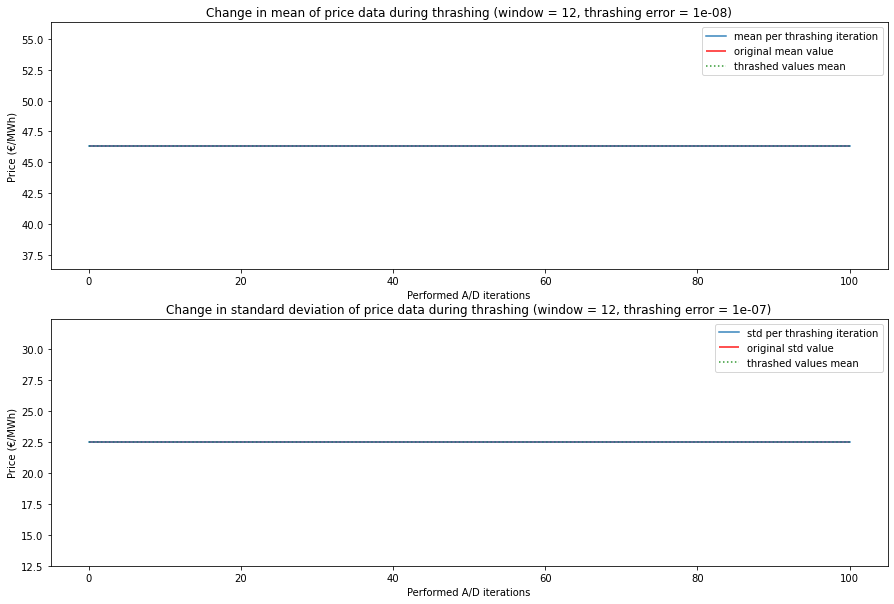

Thrashing test took 63.244 seconds, 0.632 seconds per A/D round





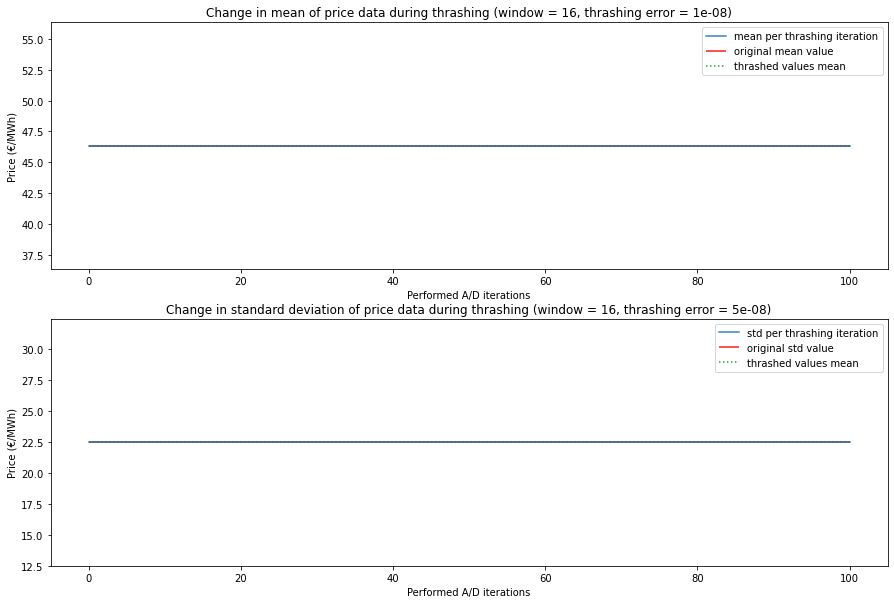

Thrashing test took 63.956 seconds, 0.64 seconds per A/D round





In [13]:
# perform thrashing tests for each rolling average window

thrash_4 = thrashing_test(df2,100,4,plot=True)
thrash_8 = thrashing_test(df2,100,8,plot=True)
thrash_12 = thrashing_test(df2,100,12,plot=True)
thrash_16 = thrashing_test(df2,100,16,plot=True)


#error is 10 -8

lower error due to error being spread over a larger subsection of values


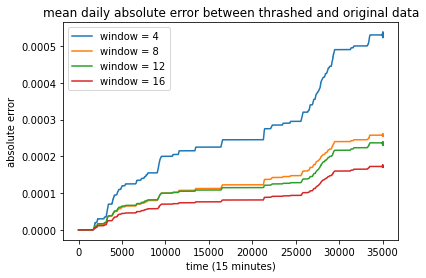

In [14]:
# plot error progression of reversal functions using thrashed data

difference_thrash_4 = pd.DataFrame([abs(thrash_4[2][i]-original_data[i]) for i in range(len(thrash_4[2]))])
difference_thrash_8 = pd.DataFrame([abs(thrash_8[2][i]-original_data[i]) for i in range(len(thrash_8[2]))])
difference_thrash_12 = pd.DataFrame([abs(thrash_12[2][i]-original_data[i]) for i in range(len(thrash_12[2]))])
difference_thrash_16 = pd.DataFrame([abs(thrash_16[2][i]-original_data[i]) for i in range(len(thrash_16[2]))])


plt.plot(create_rolling_average(difference_thrash_4,24*4),label = 'window = 4')
plt.plot(create_rolling_average(difference_thrash_8,24*4),label = 'window = 8')
plt.plot(create_rolling_average(difference_thrash_12,24*4),label = 'window = 12')
plt.plot(create_rolling_average(difference_thrash_16,24*4),label = 'window = 16')

plt.title('mean daily absolute error between thrashed and original data')
plt.ylabel('absolute error')
plt.xlabel('time (15 minutes)')
plt.legend()

print('lower error due to error being spread over a larger subsection of values')

In [15]:
df_output = pd.DataFrame()

#df_output['Electricity_price'] = df2['electricity price 15min'].rolling(window = 4, center= True, min_periods = 1).mean()
#df_output['Electricity_price'] = df2['electricity price 15min'].rolling(window = 8, center= True, min_periods = 1).mean()
#df_output['Electricity_price'] = df2['electricity price 15min'].rolling(window = 12, center= True, min_periods = 1).mean()
df_output['Electricity_price'] = df2['electricity price 15min'].rolling(window = 16, center= True, min_periods = 1).mean()

In [16]:
#df_output.to_csv('price_disagg_16.csv')

# The following cells plot results from the EVM sensitivity analysis

In [17]:
dfnormal_run = pd.read_csv('SensitivityV2_scen2_rep1_evs1_price1.csv')
dfrolling_4 = pd.read_csv('Price_disagg_4_scen1_rep1_evs0.9_price1.csv')
dfrolling_8 = pd.read_csv('Price_disagg_8_scen1_rep1_evs0.9_price1.csv')
dfrolling_12 = pd.read_csv('Price_disagg_12_scen1_rep1_evs0.9_price1.csv')
dfrolling_16 = pd.read_csv('Price_disagg_16_scen1_rep1_evs0.9_price1.csv')

In [18]:
def comparison(dforiginal,dfcompare,Start,Stop,label_name,compare_name):
    '''
    compares of various EVM KPI's when ran with original data or with
    disaggregated data
    
    Input:
    dforiginal: dataframe containing run results using original inputs
    dforiginal: dataframe containing run results using disaggregated inputs
    start: integer, plot window start
    stop: integer, plot window end
    label_name: string, name to label data in graph
    compare_name: string, name to state disaggregation method used in comparison
    
    Output:
    none
    '''
    plt.figure(figsize=(15,5))
    start = Start
    stop = Stop
    x = np.linspace(0,stop-start,stop-start)
    plt.plot(x,dfcompare['total_current_power_demand'][start:stop],label='Power demand, {} price'.format(label_name),alpha=0.9)
    plt.plot(x,dforiginal['total_current_power_demand'][start:stop],label='Power demand, original price',alpha=0.75,linestyle=':')
    plt.plot(x,dfcompare['total_VTG_capacity'][start:stop],label='VTG capacity, {} price'.format(label_name),alpha=0.9)
    plt.plot(x,dforiginal['total_VTG_capacity'][start:stop],label='VTG capacity, original price',alpha=0.75,linestyle=':')
    plt.title("EVM KPI's behaviour comparison: {}".format(compare_name))
    plt.ylabel('Electricity (KW)')
    plt.xlabel('Time (15 min)')
    plt.legend()
    plt.show()


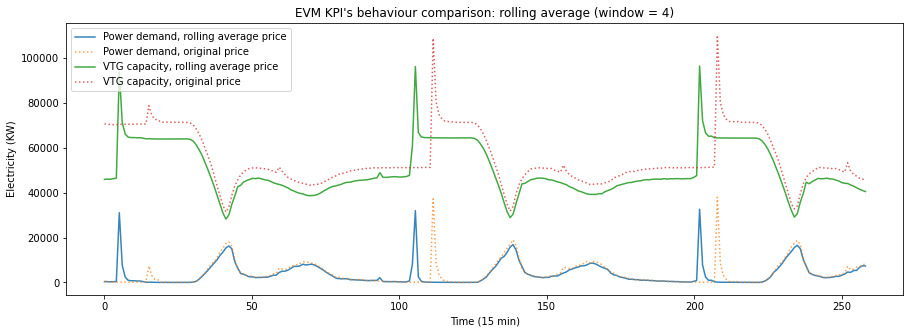

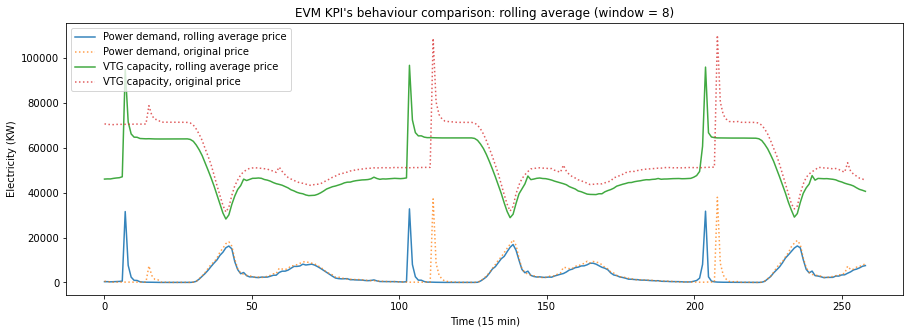

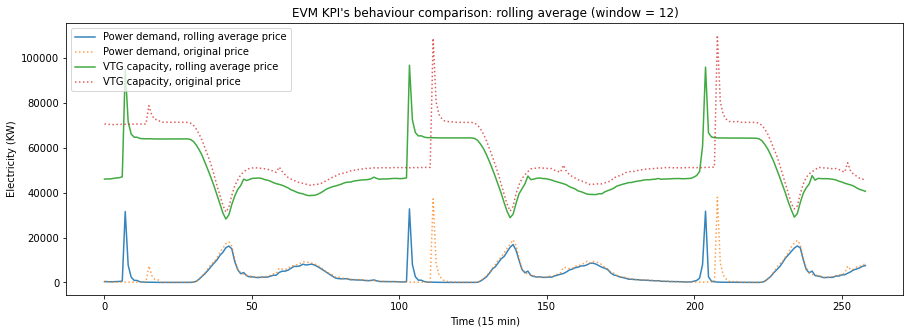

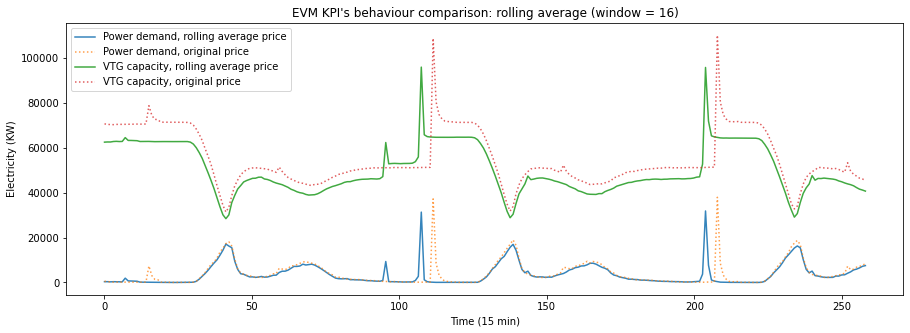

In [19]:
# compare run results

comparison(dfnormal_run,dfrolling_4,192,450,'rolling average','rolling average (window = 4)')
comparison(dfnormal_run,dfrolling_8,192,450,'rolling average','rolling average (window = 8)')
comparison(dfnormal_run,dfrolling_12,192,450,'rolling average','rolling average (window = 12)')
comparison(dfnormal_run,dfrolling_16,192,450,'rolling average','rolling average (window = 16)')

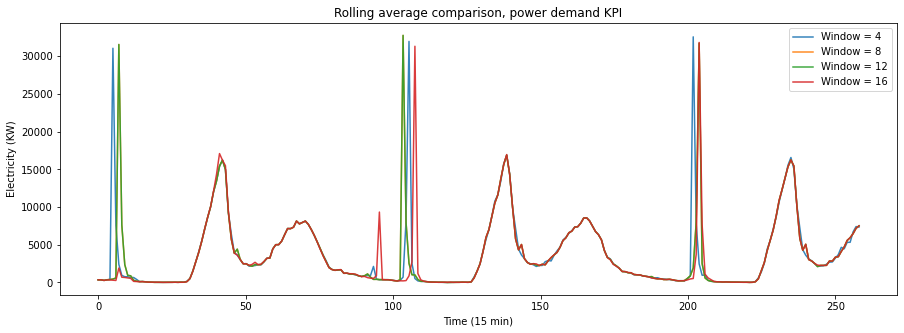

In [22]:
# compare run results in one graph, power demand KPI

start = 192
stop = 450
X = np.linspace(0,stop-start,stop-start)
plt.figure(figsize=(15,5))
plt.plot(X,dfrolling_4['total_current_power_demand'][start:stop],label='Window = 4',alpha=0.9)
plt.plot(X,dfrolling_8['total_current_power_demand'][start:stop],label='Window = 8',alpha=0.9)
plt.plot(X,dfrolling_12['total_current_power_demand'][start:stop],label='Window = 12',alpha=0.9)
plt.plot(X,dfrolling_16['total_current_power_demand'][start:stop],label='Window = 16',alpha=0.9)

plt.title("Rolling average comparison, power demand KPI")
plt.ylabel('Electricity (KW)')
plt.xlabel('Time (15 min)')
plt.legend()
plt.show()


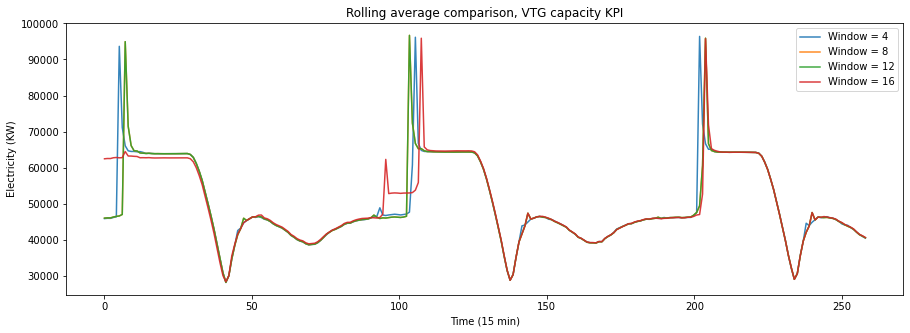

In [23]:
# compare run results in one graph, VTG capacity KPI

start = 192
stop = 450
xx = np.linspace(0,stop-start,stop-start)
plt.figure(figsize=(15,5))

plt.plot(xx,dfrolling_4['total_VTG_capacity'][start:stop],label='Window = 4',alpha=0.9)
plt.plot(xx,dfrolling_8['total_VTG_capacity'][start:stop],label='Window = 8',alpha=0.9)
plt.plot(xx,dfrolling_12['total_VTG_capacity'][start:stop],label='Window = 12',alpha=0.9)
plt.plot(xx,dfrolling_16['total_VTG_capacity'][start:stop],label='Window = 16',alpha=0.9)
plt.title("Rolling average comparison, VTG capacity KPI")
plt.ylabel('Electricity (KW)')
plt.xlabel('Time (15 min)')
plt.legend()
plt.show()